In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from matplotlib.patches import Rectangle
from astropy.cosmology import Planck18_arXiv_v2
import time
mpl.rc('font', family='serif', serif = "cmr10", size=18)
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams["errorbar.capsize"] = 5
mpl.rcParams['axes.unicode_minus'] = False
DIRECTORY = '/mnt/44868D0F868D02A2/Users/veome/Google Drive/Academics/Senior Thesis/Code/Catalog/'

In [2]:
# cosmos = np.genfromtxt(DIRECTORY+'acs_cosmos1361.gcat_ascii', usecols=range(0,10), invalid_raise=False)
cosmos = np.genfromtxt(DIRECTORY+'superbit_cosmos1361.gcat_ascii', usecols=range(0,12), invalid_raise=False)

#  Redshift > 0
cosmos = cosmos[cosmos[:,2]>0]

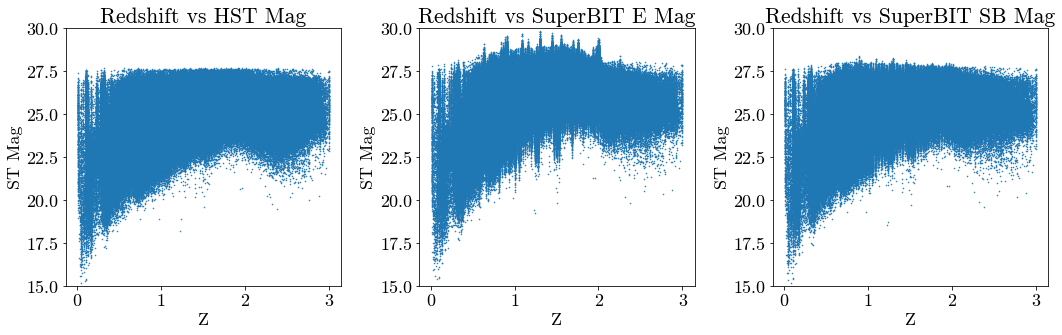

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.scatter(cosmos[:,2], cosmos[:,5], label="HST Mags", s=0.3)
ax1.set_title('Redshift vs HST Mag')
ax1.set_ylim([15.0, 30.0])

ax2.scatter(cosmos[:,2], cosmos[:,10], label="SuperBIT E Mags", s=0.3)
ax2.set_title('Redshift vs SuperBIT E Mag')
ax2.set_ylim([15.0, 30.0])

ax3.scatter(cosmos[:,2], cosmos[:,11], label="SuperBIT SB Mags", s=0.3)
ax3.set_title('Redshift vs SuperBIT SB Mag')
ax3.set_ylim([15.0, 30.0])

for ax in (ax1, ax2, ax3):
    ax.set(xlabel='Z', ylabel='ST Mag')

fig.tight_layout()
# plt.savefig(DIRECTORY+'all_mags.png')

$ \mathrm{FWHM} \approx 2.355 \sigma $

Minimum Separation for Resolution = $1.22 \frac{\lambda}{D} \approx  \mathrm{ FWHM}$

For the Shape Band in SuperBIT, $\lambda = 680 \times 10^{-9} \mathrm{m}$

$$\theta_d \approx 1.22 \frac{\lambda}{0.5 \mathrm{m}}\approx 0.342 "$$

$$\theta_{\text{res}} = \sqrt{\theta_d^2 + \theta_{\text{jitter}}^2} \approx 0.362 "$$



For F814W Band in SuperBIT, $\lambda = 814 \times 10^{-9} \mathrm{m}$

$$\theta_d \approx 1.22 \frac{\lambda}{0.5 \mathrm{m}}\approx 0.410 "$$

$$\theta_{\text{res}} = \sqrt{\theta_d^2 + \theta_{\text{jitter}}^2} \approx 0.426 "$$

In [4]:
# Calculate SuperBIT PSF
lam = 680 * u.nm
theta = 1.22 * lam  * u.rad / (0.5*u.m) # in radians
theta = theta.to(u.arcsec) # in arcsec to combine with jitter
jitter = 0.118 * u.arcsec

psf = np.sqrt(jitter**2 + theta**2)
SUPERBIT_PSF = psf.to(u.arcsec).value # in arcsec
print("SuperBIT PSF: %.3f\"" %SUPERBIT_PSF)

# Calculate SuperBIT PSF for f814W Mags
lam = 814 * u.nm
theta = 1.22 * lam  * u.rad / (0.5*u.m) # in radians
theta = theta.to(u.arcsec) # in arcsec to combine with jitter
jitter = 0.118 * u.arcsec

psf = np.sqrt(jitter**2 + theta**2)
SUPERBIT_F814W_PSF = psf.to(u.arcsec).value # in arcsec
print("SuperBIT F814W PSF: %.3f\"" %SUPERBIT_F814W_PSF)



SuperBIT PSF: 0.362"
SuperBIT F814W PSF: 0.426"


In [5]:
PIX_TO_ARCSEC = 0.05 # arcsec per HST ACS pixel (Koekemoer et. al. 2007)
ARCSEC_TO_PIX = 1/PIX_TO_ARCSEC # HST ACS pixel per arcsec

In [6]:
def get_cat_subset(cat,center,ra_range=0.5*u.arcmin,dec_range=0.5*u.arcmin, sizecut=None, magcut=None, super_e_mag=None, super_sb_mag=None, zcut=None):
    """ get a square subset the catalogue centered at a given position and a size cut in arcseconds"""

    ra_range = ra_range.to(u.deg).value
    dec_range = dec_range.to(u.deg).value
    
    subset = cat[cat[:,1]<center[1]+dec_range]
    subset = subset[subset[:,1]>center[1]-dec_range]

    subset = subset[subset[:,0]<center[0]+ra_range]
    subset = subset[subset[:,0]>center[0]-ra_range]
    
    if sizecut is not None:
        sizecut = sizecut*ARCSEC_TO_PIX
        subset = size_cut(subset,sizecut)
    
    if magcut is not None:
        subset = subset[subset[:,5]<=magcut]
    
    if super_e_mag is not None:
        subset = subset[subset[:,10]<=super_e_mag]
    
    if super_sb_mag is not None:
        subset = subset[subset[:,11]<=super_sb_mag]

    if zcut is not None:
        subset = subset[subset[:,2]<=zcut]
    
    return subset

def size_cut(cat,size):
    """ Perform a size cut on the catalogue"""
    temp = np.copy(cat)
    # temp[:,7] = (cat[:,7]*u.kpc/(Planck18_arXiv_v2.angular_diameter_distance(cat[:,2])/u.radian)).decompose().to(u.arcsec).value
    return cat[temp[:,9]*PIX_TO_ARCSEC >size]


def mag_cut(cat,mag):
    return cat[cat[:,5]<=mag]



In [7]:
# get blend ratio for objects in one arcmin^2 around center, greater than size and lower than magnitude
def get_blend_ratio(cosmos, center, psf, ra_range=0.5*u.arcmin, dec_range=0.5*u.arcmin, size=None, mag=None, super_e_mag=None, super_sb_mag=None, zcut=None):
   
    # get objects with the specified size and position
    cat = get_cat_subset(cosmos,[ra,dec], ra_range=ra_range, dec_range=dec_range, sizecut=size, magcut=mag, super_e_mag=super_e_mag, super_sb_mag=super_e_mag, zcut=zcut)

    if (cat.shape[0]==0):
        return np.nan
    
    # Convert FWHM to arcsec
    cat[:,9] = cat[:,9]*PIX_TO_ARCSEC
    
    # Convert angular coordinates to arcsec
    cat[:,0] = cat[:,0]*u.degree.to(u.arcsec)
    cat[:,1] = cat[:,1]*u.degree.to(u.arcsec)
    

    distance = np.zeros((cat.shape[0], cat.shape[0]))
    blending  = np.zeros((cat.shape[0]), dtype=bool)

    # Determine blending between pairs of objects
    for i in range(0, cat.shape[0]):
        for j in range(i, cat.shape[0]):
            if i!=j:
                distance = np.sqrt(np.square(cat[i, 0]-cat[j, 0]) + np.square(cat[i, 1]-cat[j, 1]))
                # Calculate SuperBIT size
                r1 = np.sqrt(cat[i,9]**2 + psf**2)/2
                r2 = np.sqrt(cat[j,9]**2 + psf**2)/2
                if (distance < r1+r2): 
                    # # Blending Algorithm 1: Blend if distance < radii
                    # if min(r1,r2)==r1:
                    #     blending[i]=True
                    # else:
                    #     blending[j]=True
                        
                    # Blending Algorithm 2: Blend if the two objects overlap by more than 50% 
                    area = overlap_area(distance, r1, r2)
                    overlap1 = area/(np.pi * r1**2)
                    overlap2 = area/(np.pi * r2**2)

                    # Designate the smaller object as blended if needed
                    if (overlap1>0.5 or overlap2>0.5):
                        if (r1<r2):
                            blending[i]=True
                        else:
                            blending[j]=True


    # Count unblended objects
    count = np.count_nonzero(blending)
    blend_ratio = count / cat.shape[0]
    return blend_ratio



def overlap_area(d, rad1, rad2):
    """Return the area of intersection of two circles.
    The circles have radii R and r, and their centres are separated by d.
    """
    r = min(rad1, rad2)
    R = max(rad1, rad2)

    if d <= abs(R-r):
        # One circle is entirely enclosed in the other.
        return np.pi * min(R, r)**2
    if d >= r + R:
        # The circles don't overlap at all.
        return 0

    r2, R2, d2 = r**2, R**2, d**2
    alpha = np.arccos((d2 + r2 - R2) / (2*d*r))
    beta = np.arccos((d2 + R2 - r2) / (2*d*R))
    return ( r2 * alpha + R2 * beta -
             0.5 * (r2 * np.sin(2*alpha) + R2 * np.sin(2*beta))
           )


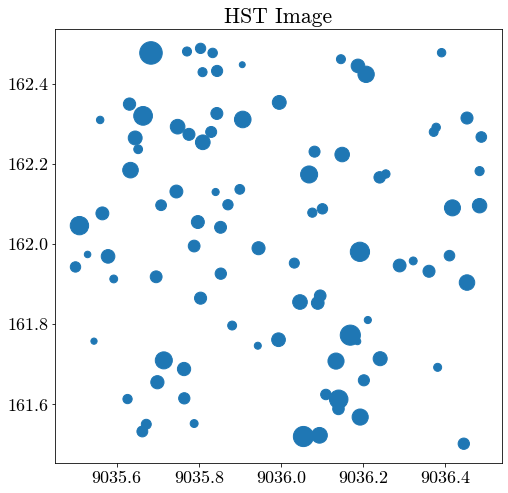

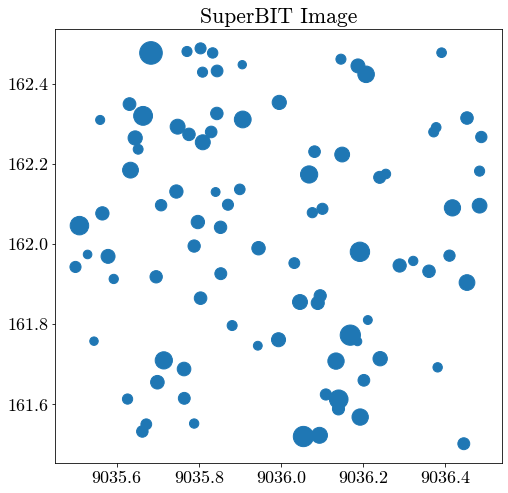

In [8]:
# Sanity check 
center = [150.6, 2.7]
test = get_cat_subset(cosmos, center)
test[:,9] = test[:,9]*PIX_TO_ARCSEC

psf = SUPERBIT_PSF
sizes_sb = np.sqrt(test[:,9]**2 + psf**2)
sizes_sb

plt.figure(figsize=(8,8))
plt.scatter(test[:,0]*u.deg.to(u.arcmin),(test[:,1]*u.deg).to(u.arcmin), s=(10000*test[:,9]*u.arcsec.to(u.arcmin)))
plt.title("HST Image")
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(test[:,0]*u.deg.to(u.arcmin),(test[:,1]*u.deg).to(u.arcmin), s=(10000*sizes_sb*u.arcsec.to(u.arcmin)))
plt.title("SuperBIT Image")
plt.show()


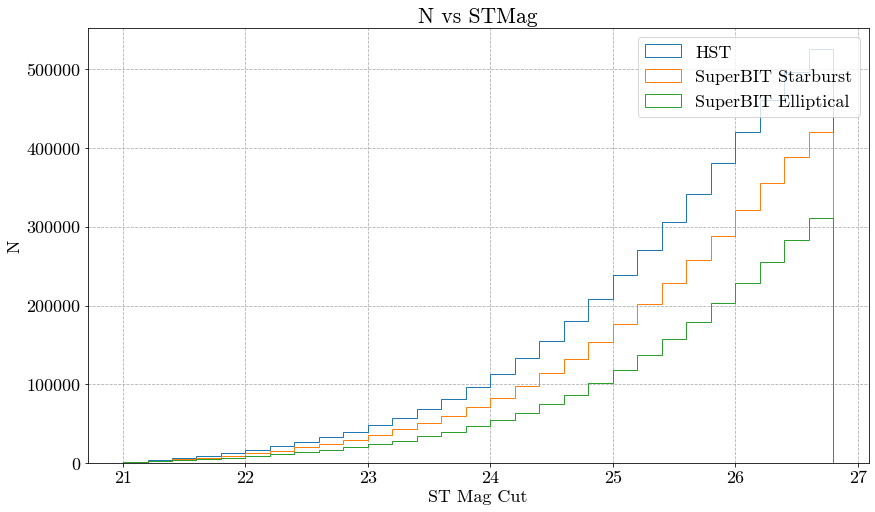

In [9]:
bins = mags = np.arange(21, 27, 0.2)
plt.figure(figsize=(14,8))

plt.hist(cosmos[:,5], bins=bins, cumulative=True, label='HST', histtype='step')
plt.hist(cosmos[:,11], bins=bins, cumulative=True, label='SuperBIT Starburst', histtype='step')
plt.hist(cosmos[:,10], bins=bins, cumulative=True, label='SuperBIT Elliptical', histtype='step')

plt.title("N vs STMag")
plt.xlabel("ST Mag Cut")
plt.ylabel('N')
plt.legend()
plt.grid(linestyle='--')

In [10]:
# HST neff vs Magnitude
hst_mag_neff = [[], [], [], [], [], [],
                [], [], [], [], [], [],
                [], [], [], [], [], []]

for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(hst_mag_neff)):
            mag = (i/2) + 21
            hst_mag_neff[i].append(get_cat_subset(cosmos,[ra,dec],magcut=mag).shape[0])

In [11]:
# neff vs E Magnitude (no blending)
sbit_e_mag_neff = [[], [], [], [], [], [],
                [], [], [], [], [], [],
                [], [], [], [], [], []]

for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(sbit_e_mag_neff)):
            mag = (i/2) + 21
            sbit_e_mag_neff[i].append(get_cat_subset(cosmos,[ra,dec],super_e_mag=mag).shape[0])

In [12]:
# neff vs Starburst Magnitude (no blending)
sbit_sb_mag_neff = [[], [], [], [], [], [],
                [], [], [], [], [], [],
                [], [], [], [], [], []]

for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(sbit_sb_mag_neff)):
            mag = (i/2) + 21
            sbit_sb_mag_neff[i].append(get_cat_subset(cosmos,[ra,dec],super_sb_mag=mag).shape[0])

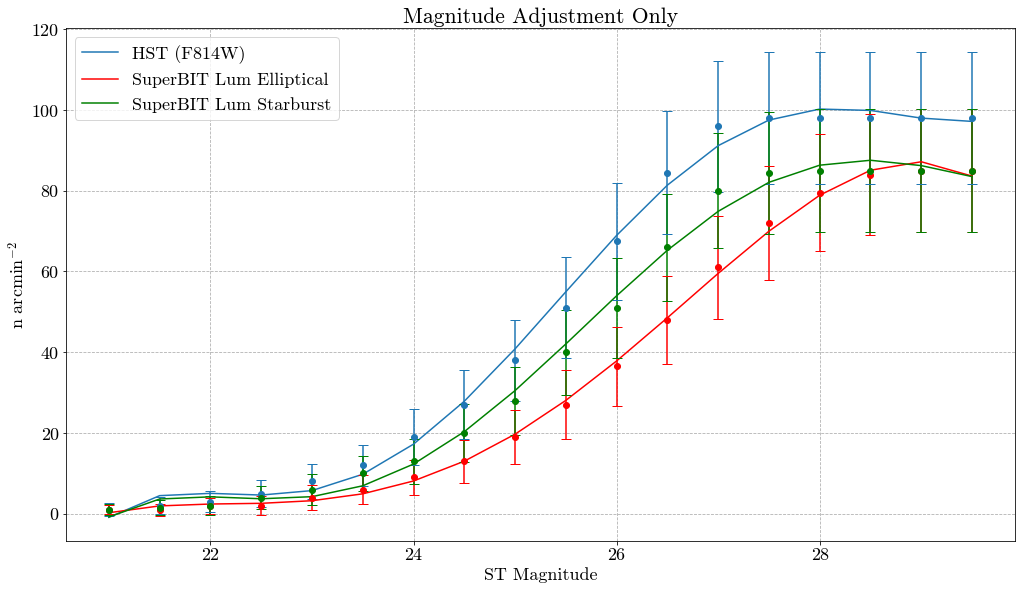

In [13]:
mags = np.arange(21, 30, 0.5)

# Plot Neff vs Magnitude (No Blending)
hst_meds = []
hst_stds = []
for i in range (len(hst_mag_neff)):
    hst_meds.append(np.nanmedian(hst_mag_neff[i]))
    hst_stds.append(np.nanstd(hst_mag_neff[i]))

e_meds = []
e_stds = []
for i in range (len(sbit_e_mag_neff)):
    e_meds.append(np.nanmedian(sbit_e_mag_neff[i]))
    e_stds.append(np.nanstd(sbit_e_mag_neff[i]))
    
sb_meds = []
sb_stds = []
for i in range (len(sbit_sb_mag_neff)):
    sb_meds.append(np.nanmedian(sbit_sb_mag_neff[i]))
    sb_stds.append(np.nanstd(sbit_sb_mag_neff[i]))
    
    

z_hst = np.polyfit(mags, hst_meds, 5)
f_hst = np.poly1d(z_hst)

z_e = np.polyfit(mags, e_meds, 5)
f_e = np.poly1d(z_e)

z_sb = np.polyfit(mags, sb_meds, 5)
f_sb = np.poly1d(z_sb)
    
# Plot n_eff
plt.figure(figsize=(14,8))

plt.plot(mags,f_hst(mags),label="HST (F814W)", color='C0')
plt.errorbar(mags, hst_meds, yerr=hst_stds,fmt='o', color='C0')

plt.plot(mags,f_e(mags),label="SuperBIT Lum Elliptical", color='r')
plt.errorbar(mags, e_meds, yerr=e_stds,fmt='o', color='r')

plt.plot(mags,f_sb(mags),label="SuperBIT Lum Starburst", color='g')
plt.errorbar(mags, sb_meds, yerr=sb_stds,fmt='o', color='g')

plt.title("Magnitude Adjustment Only")
plt.xlabel("ST Magnitude")
plt.ylabel('n arcmin$^{-2}$')
plt.legend()
plt.tight_layout(pad=0)
plt.grid(linestyle='--')

plt.show()


In [14]:
# Blending vs Magnitude (for F814W Mags)
f814w_blend_mag = [[], [], [], [], [], [],
                   [], [], [], [], [], [],
                   [], [], [], [], [], []]


for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(f814w_blend_mag)):
            mag = (i/2) + 21
            f814w_blend_mag[i].append(get_blend_ratio(cosmos, [ra, dec], SUPERBIT_F814W_PSF, mag=mag))


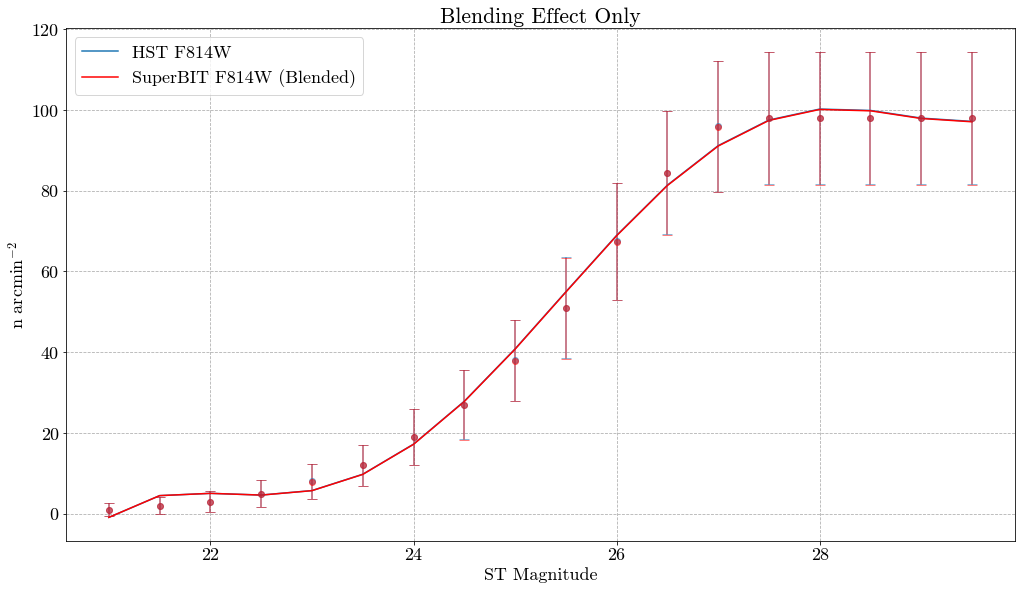

In [15]:
# HST (F814W) vs SuperBIT (F814W)
hst_meds = np.empty(len(f814w_blend_mag))
hst_stds = np.empty(len(f814w_blend_mag))

for i in range (len(hst_mag_neff)):
    hst_meds[i]= np.nanmedian(hst_mag_neff[i])
    hst_stds[i]= np.nanstd(hst_mag_neff[i])

med_blend = np.empty(len(f814w_blend_mag))
std_blend = np.empty(len(f814w_blend_mag))

for i in range(len(f814w_blend_mag)):
    med_blend[i] = np.nanmean(f814w_blend_mag[i])
    std_blend[i]= np.nanstd(hst_mag_neff[i])


sbit_meds = hst_meds - (med_blend*hst_meds)
sbit_stds = std_blend

mags = np.arange(21, 30, 0.5)

z_hst = np.polyfit(mags, hst_meds, 5)
f_hst = np.poly1d(z_hst)

z_sbit = np.polyfit(mags, sbit_meds, 5)
f_sbit = np.poly1d(z_sbit)
    
# Plot n_eff
plt.figure(figsize=(14,8))
alp=0.5
plt.plot(mags, f_hst(mags), label="HST F814W", color='C0')
plt.errorbar(mags, hst_meds, yerr=hst_stds, fmt='o', color='C0', alpha=alp)
plt.plot(mags, f_sbit(mags), label="SuperBIT F814W (Blended)", color='r')
plt.errorbar(mags, sbit_meds, yerr=sbit_stds, fmt='o', color='r', alpha=alp)

plt.title("Blending Effect Only")
plt.xlabel("ST Magnitude")
plt.ylabel('n arcmin$^{-2}$')
plt.legend()
plt.tight_layout(pad=0)
plt.grid(linestyle='--')

# plt.savefig(DIRECTORY+'blending_only_f814w_magnitude_neff.png')

In [16]:
# Blending vs Elliptical Magnitude (for SuperBIT Mags)
superbit_e_blend_mag = [[], [], [], [], [], [],
                        [], [], [], [], [], [],
                        [], [], [], [], [], []]


for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(superbit_e_blend_mag)):
            magnitude = (i/2) + 21
            superbit_e_blend_mag[i].append(get_blend_ratio(cosmos, [ra, dec], SUPERBIT_PSF, super_e_mag=magnitude))

In [17]:
# Blending vs Starburst Magnitude (for SuperBIT Mags)
superbit_sb_blend_mag = [[], [], [], [], [], [],
                         [], [], [], [], [], [],
                         [], [], [], [], [], []]


for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(superbit_sb_blend_mag)):
            magnitude = (i/2) + 21
            superbit_sb_blend_mag[i].append(get_blend_ratio(cosmos, [ra, dec], SUPERBIT_PSF, super_sb_mag=magnitude))

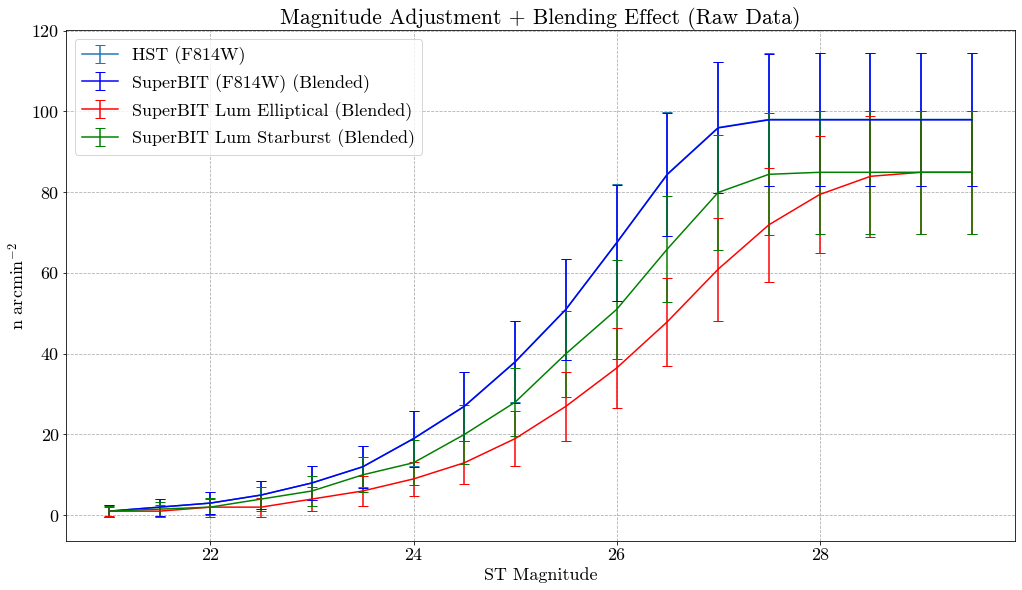

In [19]:
# Plot n_eff raw data

# HST (F814W) vs SuperBIT Neff
e_med_blend = np.empty(len(superbit_e_blend_mag))
e_std_blend = np.empty(len(superbit_e_blend_mag))

sb_med_blend = np.empty(len(superbit_sb_blend_mag))
sb_std_blend = np.empty(len(superbit_sb_blend_mag))

for i in range (len(superbit_e_blend_mag)):
    e_med_blend[i] = np.nanmean(superbit_e_blend_mag[i])
    e_std_blend[i]= np.nanstd(superbit_e_blend_mag[i])

    sb_med_blend[i] = np.nanmean(superbit_sb_blend_mag[i])
    sb_std_blend[i]= np.nanstd(superbit_sb_blend_mag[i])

# Subtract blended objects from Lum Band Neff
sbit_e_meds = e_meds - (e_med_blend*e_meds)
sbit_e_stds = e_std_blend + e_stds

sbit_sb_meds = sb_meds - (sb_med_blend*sb_meds)
sbit_sb_stds = sb_std_blend + sb_stds


plt.figure(figsize=(14,8))
alp=1

# Plot F814W Neffs
plt.errorbar(mags, hst_meds, yerr=hst_stds, label="HST (F814W)", fmt='-', color='C0', alpha=alp)
plt.errorbar(mags, sbit_meds, yerr=sbit_stds, label="SuperBIT (F814W) (Blended)", fmt='-', color='b', alpha=alp)

# Plot SuperBIT Lum Neffs
plt.errorbar(mags, sbit_e_meds, yerr=sbit_e_stds, label="SuperBIT Lum Elliptical (Blended)", fmt='-', color='r', alpha=alp)

plt.errorbar(mags, sbit_sb_meds, yerr=sbit_sb_stds, label="SuperBIT Lum Starburst (Blended)", fmt='-', color='g', alpha=alp)

plt.title("Magnitude Adjustment + Blending Effect (Raw Data)")
plt.xlabel("ST Magnitude")
plt.ylabel('n arcmin$^{-2}$')
plt.legend()
plt.tight_layout(pad=0)
plt.grid(linestyle='--')

# plt.xlim(21.1, 29)
# plt.ylim(37.5, 38.5)

# plt.savefig(DIRECTORY+'blending+magnitude_neff_raw.png')

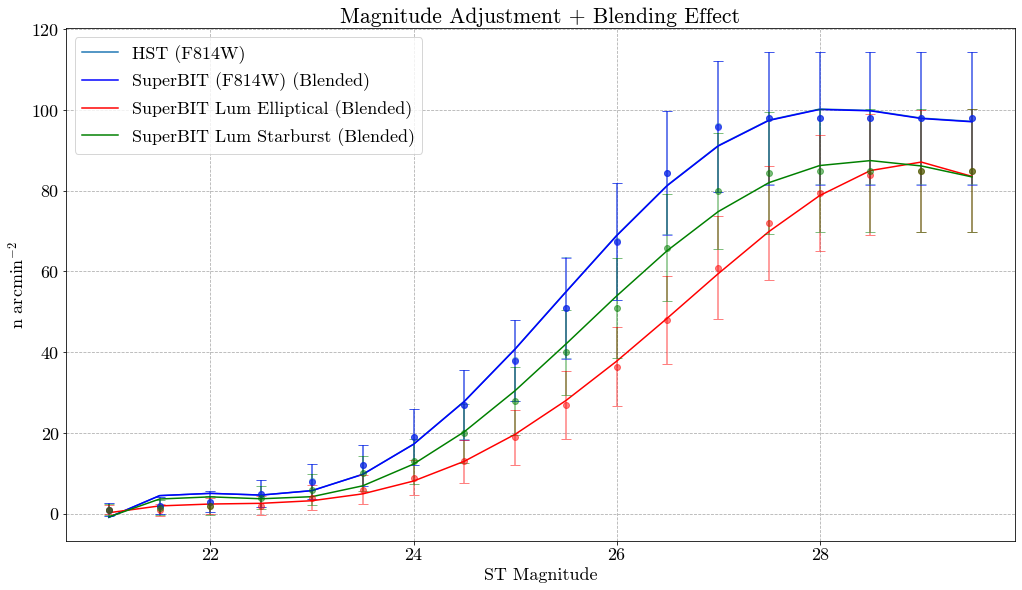

In [20]:
# Best Fit Curves
z_hst = np.polyfit(mags, hst_meds, 5)
f_hst = np.poly1d(z_hst)

z_sbit_e = np.polyfit(mags, sbit_e_meds, 5)
f_sbit_e = np.poly1d(z_sbit_e)

z_sbit_starb = np.polyfit(mags, sbit_sb_meds, 5)
f_sbit_starb = np.poly1d(z_sbit_starb)
    
# Plot n_eff
plt.figure(figsize=(14,8))
alp=0.5
alp1=1

# Plot F814W Neffs
plt.plot(mags, f_hst(mags), label="HST (F814W)", color='C0')
plt.errorbar(mags, hst_meds, yerr=hst_stds, fmt='o', color='C0', alpha=alp)
plt.plot(mags, f_sbit(mags), label="SuperBIT (F814W) (Blended)", color='b')
plt.errorbar(mags, sbit_meds, yerr=sbit_stds, fmt='o', color='b', alpha=alp)

# Plot SuperBIT Lum Neffs
plt.plot(mags, f_sbit_e(mags), label="SuperBIT Lum Elliptical (Blended)", color='r')
plt.errorbar(mags, sbit_e_meds, yerr=sbit_e_stds, fmt='o', color='r', alpha=alp)

plt.plot(mags, f_sbit_starb(mags), label="SuperBIT Lum Starburst (Blended)", color='g')
plt.errorbar(mags, sbit_sb_meds, yerr=sbit_sb_stds, fmt='o', color='g', alpha=alp)

plt.title("Magnitude Adjustment + Blending Effect")
plt.xlabel("ST Magnitude")
plt.ylabel('n arcmin$^{-2}$')
plt.legend()
plt.tight_layout(pad=0)
plt.grid(linestyle='--')

# plt.xlim(21.1, 29)
# plt.ylim(37.5, 38.5)

# plt.savefig(DIRECTORY+'blending+magnitude_neff_hst_superbit.png')